In [5]:
import pandas as pd
import numpy as np
import datetime
import matplotlib as plt
import time

In [33]:
def brute_force_clustering(gc_values, delta):
    clusters = []
    for value in gc_values:
        placed = False
        for cluster in clusters:
            # Check if value fits with all members of this cluster
            if all(abs(value - member) <= delta for member in cluster):
                cluster.append(value)
                placed = True
                break
        if not placed:
            # Start a new cluster
            clusters.append([value])
    return clusters


In [6]:
def cluster_partition(array, low, high, delta, clusters):
    if low > high:
        return
    pivot = array[high]
    i = low     # For < pivot - delta
    j = low     # For current examination
    k = high    # For > pivot + delta
    mid_cluster = []
    while j <= k:
        if array[j] < pivot - delta:
            array[i], array[j] = array[j], array[i]
            i += 1
            j += 1
        elif abs(array[j] - pivot) <= delta:
            mid_cluster.append(array[j])
            j += 1
        else:
            array[j], array[k] = array[k], array[j]
            k -= 1
    if mid_cluster:
        clusters.append(mid_cluster)
    cluster_partition(array, low, i-1, delta, clusters)
    cluster_partition(array, k+1, high, delta, clusters)

In [26]:
from Bio import SeqIO
from Bio.SeqUtils import gc_fraction

def sample_gc_content_fasta(fasta_file, N=100):
    """
    Efficiently samples the first N sequences from a large multi-fasta file for GC-content computation.
    """
    gc_list = []
    for i, record in enumerate(SeqIO.parse(fasta_file, "fasta")):
        if i >= N:
            break
        gc = gc_fraction(record.seq) * 100
        gc_list.append(gc)
    return gc_list

fasta_file = 'Gastrointestinal_tract.nuc.fsa'
gc_values = sample_gc_content_fasta(fasta_file, N=10000)
print(f"Sampled GC% of {len(gc_values)} genes. Example: {gc_values[:10]}")


Sampled GC% of 10000 genes. Example: [43.844314339902695, 41.76421720413866, 56.575963718820866, 39.38019652305367, 43.219076005961256, 45.23517382413088, 41.42368937686323, 35.346441947565545, 42.20003674894347, 43.22726904704072]


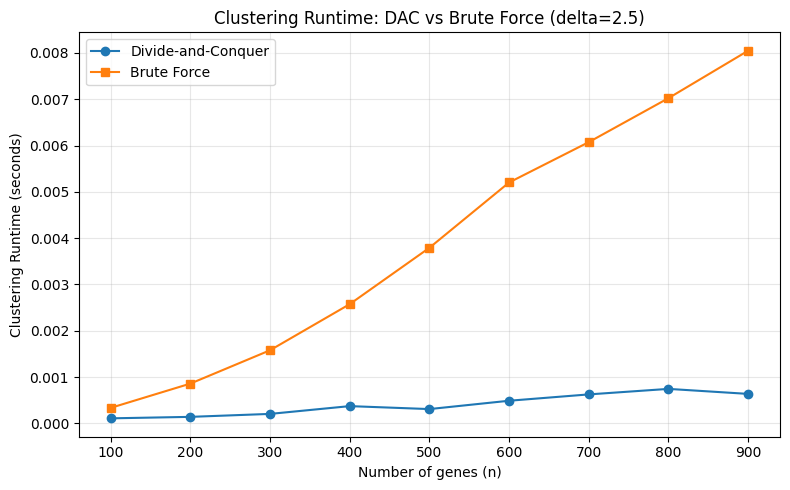

In [55]:

def runtime_analysis_on_samples(fasta_file, n_values, delta=2.5):
    run_times_dac = []
    run_times_brute = []
    cluster_counts_dac = []
    cluster_counts_brute = []

    for n in n_values:
        gc_values = sample_gc_content_fasta(fasta_file, N=n)

        # Divide-and-conquer
        clusters_dac = []
        start = time.time()
        cluster_partition(gc_values.copy(), 0, len(gc_values)-1, delta, clusters_dac)
        elapsed_dac = time.time() - start
        run_times_dac.append(elapsed_dac)
        cluster_counts_dac.append(len(clusters_dac))

        # Brute-force
        start = time.time()
        clusters_brute = brute_force_clustering(gc_values, delta)
        elapsed_brute = time.time() - start
        run_times_brute.append(elapsed_brute)
        cluster_counts_brute.append(len(clusters_brute))

        # print(f"n={n}, delta={delta} | DAC: {elapsed_dac:.5f}s, {len(clusters_dac)} clusters | Brute: {elapsed_brute:.5f}s, {len(clusters_brute)} clusters")

    plt.figure(figsize=(8,5))
    plt.plot(n_values, run_times_dac, marker='o', label='Divide-and-Conquer')
    plt.plot(n_values, run_times_brute, marker='s', label='Brute Force')
    plt.xlabel("Number of genes (n)")
    plt.ylabel("Clustering Runtime (seconds)")
    plt.title(f"Clustering Runtime: DAC vs Brute Force (delta={delta})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# Usage example
fasta_file = 'Gastrointestinal_tract.nuc.fsa'
n_values = list(range(100, 1000, 100))
delta = 2.5
runtime_analysis_on_samples(fasta_file, n_values, delta)


In [59]:
gc_values = sample_gc_content_fasta(fasta_file, N=1000)
delta = 2.5
clusters = []
cluster_partition(gc_values.copy(), 0, len(gc_values)-1, delta, clusters)

L, U = 25, 60 # Define native range for gut bacteria

anomalous_clusters = []
normal_clusters = []

for clust in clusters:
    if len(clust) == 0:
        continue  
    mean_gc = sum(clust) / len(clust)
    if mean_gc < L or mean_gc > U:
        anomalous_clusters.append({"mean_gc": mean_gc, "size": len(clust), "values": clust})
    else:
        normal_clusters.append({"mean_gc": mean_gc, "size": len(clust), "values": clust})

print(f"Detected {len(anomalous_clusters)} anomalous clusters:")
for entry in anomalous_clusters:
    print(f"  Cluster: mean GC={entry['mean_gc']:.2f}%, size={entry['size']}")

print(f"\nNormal clusters count: {len(normal_clusters)}")
normal_gc_means = [entry['mean_gc'] for entry in normal_clusters]
if normal_gc_means:
    overall_normal_mean_gc = sum(normal_gc_means) / len(normal_gc_means)
    print(f"Mean GC content of normal clusters: {overall_normal_mean_gc:.2f}%")
else:
    print("No normal clusters to compute mean GC content.")





Detected 2 anomalous clusters:
  Cluster: mean GC=64.02%, size=9
  Cluster: mean GC=60.25%, size=16

Normal clusters count: 9
Mean GC content of normal clusters: 41.01%
